In [4]:

import pandas as pd
import numpy as np

customer = pd.read_csv("customer_hm.csv")
transactions = pd.read_csv("transactions_hm.csv")
articles = pd.read_csv("articles_hm.csv")

#copy
df_cust = customer.copy()
df_tran = transactions.copy()
df_art = articles.copy()

In [5]:
print(df_art.head())

   article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid               

In [6]:
df_art.info()

<class 'pandas.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  int64
 1   product_code                  105542 non-null  int64
 2   prod_name                     105542 non-null  str  
 3   product_type_no               105542 non-null  int64
 4   product_type_name             105542 non-null  str  
 5   product_group_name            105542 non-null  str  
 6   graphical_appearance_no       105542 non-null  int64
 7   graphical_appearance_name     105542 non-null  str  
 8   colour_group_code             105542 non-null  int64
 9   colour_group_name             105542 non-null  str  
 10  perceived_colour_value_id     105542 non-null  int64
 11  perceived_colour_value_name   105542 non-null  str  
 12  perceived_colour_master_id    105542 non-null  int64
 13  perceived_colour_master_n

In [7]:
### customer 테이블 전처리
# fashion_news_frequency가 결측치인 데이터만 추출
missing_data = customer[customer['fashion_news_frequency'].isnull()]

# FN이 1이고, Active가 0인 fashion_news_frequency의 고유값별 빈도 확인
customer[(customer['FN'] == 1) & (customer['Active'] == 0)
]['fashion_news_frequency'].value_counts(dropna=False)

# 결측치 'Regularly'으로 채우기
customer['fashion_news_frequency'] = customer['fashion_news_frequency'].fillna('Regularly')

#  (문자형 정수형으로 매핑) 사전 정의
status_map = {'ACTIVE': 2, 'PRE-CREATE': 1, 'LEFT CLUB': 0}
frequency_map = {'Regularly': 2, 'Monthly': 1, 'NONE': 0}

#  매핑 적용
customer['club_member_status'] = customer['club_member_status'].map(status_map)
customer['fashion_news_frequency'] = customer['fashion_news_frequency'].map(frequency_map)

# 나이를 나이대별로 나눠 파생변수 생성
def cate_age(age):
    if age < 20: return '10대'
    elif age < 30: return '20대'
    elif age < 40: return '30대'
    elif age < 50: return '40대'
    elif age < 60: return'50대'
    else: return '60대 이상'

customer['age_segment'] = customer['age'].apply(cate_age)

customer.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,age_segment
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,2,0,49,40대
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,2,0,25,20대
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,2,0,24,20대
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,2,0,54,50대
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,2,2,52,50대


In [8]:
### Transaction 테이블 전처리

#4. 날짜 타입 변환
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
transactions.info()


# 5. 판매 채널 컬럼 생성
transactions["판매 채널"] = transactions["sales_channel_id"].map({1: "오프라인", 2: "온라인"})
transactions["판매 채널"].value_counts() 
numbs = transactions["판매 채널"].value_counts()
print("온라인:", f"{numbs['온라인']:,}")
print("오프라인:", f"{numbs['오프라인']:,}")
print("전체 거래 건수:", f"{transactions.shape[0]:,}")


# 6. 가격 데이터 분포 확인
transactions['price'].describe() 
print("price가 0.1 이상:", len(transactions[transactions["price"] >= 0.1]))
print("price가 0.2 이상:", len(transactions[transactions["price"] >= 0.2]))
print("price가 0.3 이상:", len(transactions[transactions["price"] >= 0.3]))
print("price가 0.4 이상:", len(transactions[transactions["price"] >= 0.4]))
print("price가 0.5 이상:", len(transactions[transactions["price"] >= 0.5]))


#7. 고가 거래 분리 및 채널 확인
high_price_transactions = transactions[transactions["price"] >= 0.4]
high_price_transactions['sales_channel_id'].replace({1: 'Offline', 2: 'Online'}).value_counts() 


#8. 날짜 범위 확인
transactions["t_dat"].describe()


#9. 월 컬럼 생성
transactions['year_month'] = transactions['t_dat'].dt.to_period('M') 


#10. 월별 거래 건수 & 매출액 계산
monthly_sales = transactions.groupby('year_month').size()
monthly_price = transactions.groupby('year_month')['price'].sum()


#11. 최고 매출 월 
best_month = monthly_price.idxmax()
best_value = monthly_price.max()

print("가장 매출이 높은 달:", best_month)
print("그 달의 매출:", best_value) 


<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1048575 non-null  datetime64[us]
 1   customer_id       1048575 non-null  str           
 2   article_id        1048575 non-null  int64         
 3   price             1048575 non-null  float64       
 4   sales_channel_id  1048575 non-null  int64         
dtypes: datetime64[us](1), float64(1), int64(2), str(1)
memory usage: 40.0 MB
온라인: 729,192
오프라인: 319,383
전체 거래 건수: 1,048,575
price가 0.1 이상: 10803
price가 0.2 이상: 724
price가 0.3 이상: 127
price가 0.4 이상: 29
price가 0.5 이상: 2
가장 매출이 높은 달: 2019-06
그 달의 매출: 3113.444654044


* 기존 
    * detail_desc 결측치 처리 
    * 상품 
* 추가 
    * 데이터 타입 변환(article_id)
    * 메모리 차지하는 불필요 컬럼 제거(colour_group_name가 있으니 colour_group_code 불필요. 코드 번호가 이름의 정보를 100% 포함하고 있기 때문에 불필요. 다만 선택사항이긴함)
        * 불필요 컬럼 제거하면 혹시 다른 테이블에 영향이 갈까? (데이터 정합성)
        * → '코드성' 컬럼들을 삭제해도 다른 테이블과의 연결(Join)에는 전혀 지장이 없다는 확인 받음
    * 데이터 타입 변환: article_id를 10자리 문자열로 (앞자리 0 보존)
    * 파생변수 : (임시. 팀원과 공유하고 수정할 부분은 수정할 것)
        * Beach & Swim : Swimwear 전체 
            * 20대의 구매가 높을 것으로 예상되기도 함
        * Outdoor & Outer : Coat, Jacket, Outdoor
            * 고연령의 구매가 높을 것으로 예상되기도 함
        * Daily Basics : Jersey Basic, Underwear, T-shirt
            * 전 연령대가 구매하지만 채널 선호도가 갈릴 수 있는 품목
        * Accessories & Shoes : Accessories, Shoes, Bags
            * 온라인에서 구매하기 쉬운 품목이지 않을까

-> 음 데이터 확인하면서 고연령, 저연령대가 정말로 구매 비중이 높은지 먼저 확인하는 게 필요하지 않을까? 매핑할 때 중요한 요소 같은데 이 과정에서 확인하고 넘어가는 게 맞지 않나 싶은데
-> 탐색적 데이터 분석(EDA) 단계를 거치면서 우리가 설정한 가설을 먼저 세워야 할 수도. 팀원들끼리 상의해야 할듯 지금은 임시 매핑 & 가설 수립해서 진행하고, 회의에서 EDA 순서 맞추는 게 필요. 최종 매핑은 회의 이후!

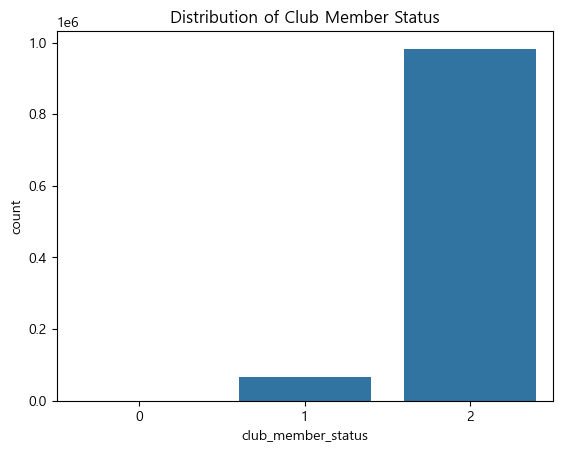

In [9]:
### 추가 EDA 시각화
# club_member_status 시각화로 확인하려면 아래처럼
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=customer, x='club_member_status')
plt.title("Distribution of Club Member Status")
plt.show()

### 2프로의 EDA 수행 단계
* 목표
    * 데이터가 어떻게 생겼는지 파악
    * 값이 이상한 부분(결측치, 이상치) 발견
    * 변수 간 관계에 대한 가설 생성
    * 이후 분석/모델링 방향 결정

1. 기초 통계 및 결측치 확인
    * 각 테이블의 행/열 개수(shape), 데이터 타입, 결측치(isnull), 기초 통계량(describe) 확인
2. 단일 변수 탐색 (Univariate Analysis)
    * 나이 분포(히스토그램), 상품 카테고리 비중(막대그래프), 회원 상태 비율 확인
    * "우리 고객은 주로 몇 살인지, 어떤 상품이 제일 많은지" 등 확인
3. 두 변수 간의 관계 탐색 (Bivariate Analysis) (중요!!!)
    * 연령대별 선호 상품군, 요일별 구매 건수, 채널별 매출액 비교.
    * "진짜로 20대가 수영복을 많이 샀을까?"처럼 두 정보 사이의 상관관계를 확인
4. 이상치 및 특이 패턴 심화 탐색
    * 나이가 100세인 고객의 구매 기록만 따로 보거나, 특정 날짜에 매출이 폭발한 이유 확인.
5. 인사이트 요약 및 전처리 방향 확정 (최종 결론 내리기)
    * 확인 결과 50대는 아우터보다 니트를 선호하니, 매핑 시 니트를 아우터 그룹에 포함하자 등의 결정
    * EDA 결과를 바탕으로 실제 분석에 쓸 **최종 파생변수와 매핑 로직**을 설계

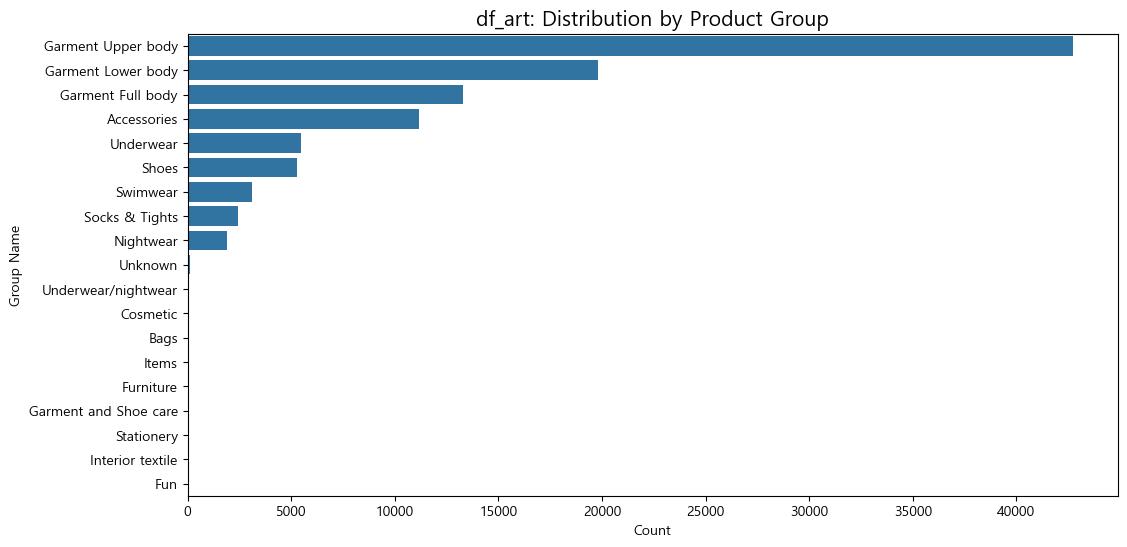

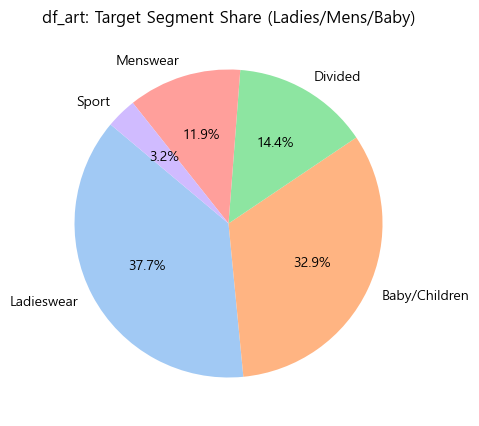

In [10]:

###EDA용 시각화 (w. ai튜터...)
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 상품 그룹(product_group_name)별 분포 확인
plt.figure(figsize=(12, 6))
sns.countplot(data=df_art, y='product_group_name', order=df_art['product_group_name'].value_counts().index)
plt.title('df_art: Distribution by Product Group', fontsize=15)   #상품 그룹별 데이터 분포
plt.xlabel('Count') #상품 수
plt.ylabel('Group Name')    #그룹명
plt.show()

# 2. 가설 검증용: index_group_name(타겟층) 분포 확인
plt.figure(figsize=(10, 5))
df_art['index_group_name'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('df_art: Target Segment Share (Ladies/Mens/Baby)')
plt.ylabel('')
plt.show()

### EDA 시각화 후 해석 (첫번째 시각화)
* 1. Articles: Distribution by Product Group (상품 그룹별 데이터 분포)
    * Y축 (Group Name)
        * Garment Upper body (상의류): 약 42,000개 이상으로 압도적 1위
        * Garment Lower body (하의류): 약 20,000개 수준
        * Garment Full body (전신 의류): 약 13,000개 수준
        * Accessories (액세서리): 약 11,000개 수준
        * Underwear (속옷): 약 5,000개 수준
        * Shoes (신발): 약 5,000개 미만
        * Swimwear (수영복): 약 3,000개 수준
    * X축 (Count): 상품의 총 개수 (0 ~ 40,000+)
* 2. Articles: Target Segment Share (타겟 고객층 비중)
        * Ladieswear (여성복): 37.7% (가장 큰 비중)
        * Baby/Children (유아/아동): 33.0%
        * Divided (MZ 타겟): 14.4%
        * Menswear (남성복): 11.9%
        * Sport (스포츠): 3.0%

1. Garment Upper/Lower/Full body의 압도적으로 비중이 큼
    * 상의가 압도적 1위, 하의, 풀바디(전신) 의류가 다음으로 
2. Swimwear는 중위권이다. 
    * 20대의 구매가 많을 것으로 보이는 품목이 분석 대상으로 적절할만한 중간에 위치함! 통계적으로 유의미한 수치가 나올 수 있겠다는 판단 가능
3. 정제의 필요성이 있는 극단치들(매우 낮은 값 존재)
    * Bags, Items, Furniture 등


### EDA 시각화 후 해석 (두번째 시각화)
1. 여성복(Ladieswear)이 가장 큰 비중을 차지함. 20대 여성의 온라인 쇼핑 패턴 분석하기 용이할 것 같다
2. 아동복(Baby/Children) 비중이 두번째로 크다. 
    * 30대의 구매가 높은 걸까? 아니면 선물용? 20대의 쇼핑 목록에는 거의 없겠지만 30대(본인 자녀용), 50대(손주 선물용) 등의 패턴이 나올 수도 있겠다
3. 남성복(Menswear)과 스포츠(Sport)는 상대적으로 낮다. 서브 인사이트 용으로 두는 게 전략적으로 용이할 것이다.
4. divided
    * 이게 뭐..뭐지? 기타 품목인가 싶었는데 H&M의 MZ 타켓팅 라인(크롭, 스트릿 패션 디자인)을 모아둔 것
    * 2026년 기준 현재에도 스웨덴 및 글로벌 시장에서 dicided 라인 확실히 있으나 한국 웹사이트 기준에서는 보이지는 않음. 무신사 used(중고) 디바이디드에이치앤엠 이라는 이름으로 판매되고 있으나 공식 웹사이트에서는 카테고리 따로 X
    * https://divided.brandswebsites.com/?utm_source=chatgpt.com

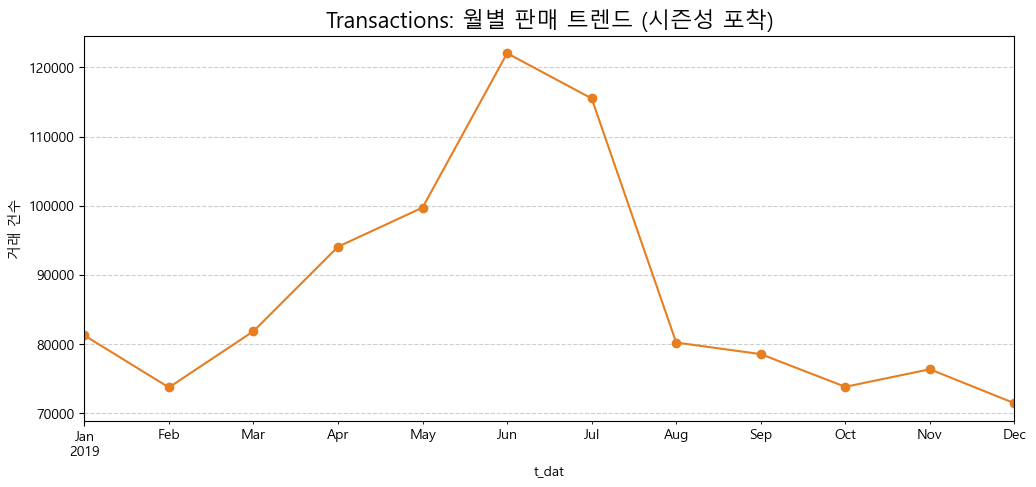

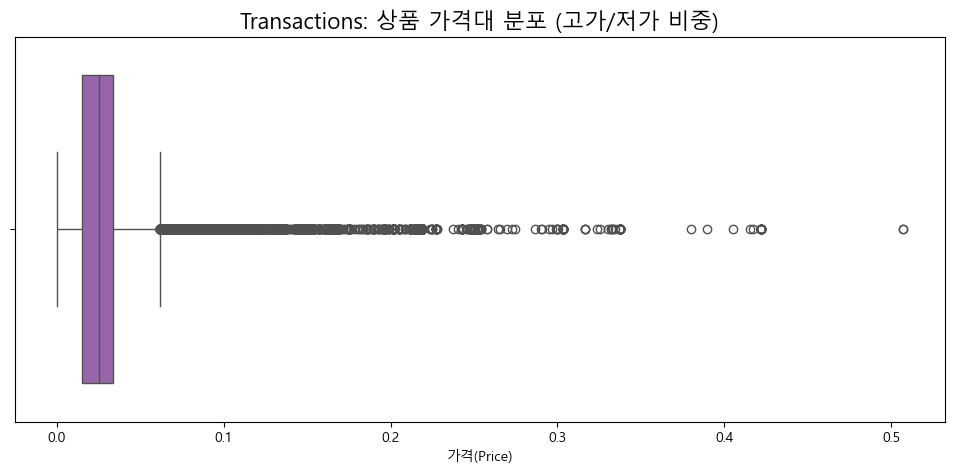

In [11]:
######## EDA 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 폰트 깨짐 방지를 위한 설정 (Windows 기준 Malgun Gothic)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

#[transactions]
# 1. 월별 거래량 추이 (시즌성 확인)
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
monthly_sales = transactions.set_index('t_dat').resample('ME').size()

plt.figure(figsize=(12, 5))
monthly_sales.plot(marker='o', color='#e67e22') 
plt.title('Transactions: 월별 판매 트렌드 (시즌성 포착)', fontsize=16)
plt.ylabel('거래 건수')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. 가격대 분포 (이상치 및 주력 가격대 확인)
plt.figure(figsize=(12, 5))
sns.boxplot(x=transactions['price'], color='#9b59b6') 
plt.title('Transactions: 상품 가격대 분포 (고가/저가 비중)', fontsize=16)
plt.xlabel('가격(Price)')
plt.show()


### [transaction] 시각화 해석

### [차트 1]



### [차트 2]

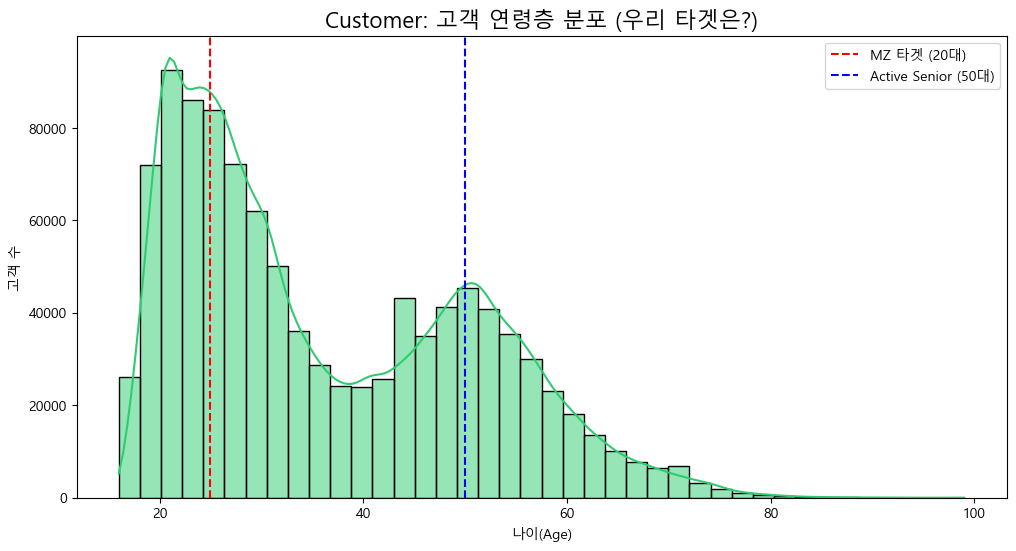

In [12]:
######## EDA 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 폰트 깨짐 방지를 위한 설정 (Windows 기준 Malgun Gothic)
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

#[customer]
import matplotlib.pyplot as plt
import seaborn as sns

# 고객 연령대 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(customer['age'], bins=40, kde=True, color='#2ecc71')
plt.axvline(25, color='red', linestyle='--', label='MZ 타겟 (20대)') 
plt.axvline(50, color='blue', linestyle='--', label='Active Senior (50대)')

plt.title('Customer: 고객 연령층 분포 (우리 타겟은?)', fontsize=16)
plt.xlabel('나이(Age)')
plt.ylabel('고객 수')
plt.legend()
plt.show()

### [customer] 시각화 해석
* 



##데이터 분석 진행도
1. 데이터 로드 -완료
2. EDA (탐색·확인·가설 세우기) -완료
3. 전처리 (EDA에서 발견한 문제를 실제로 수정)
4. 전처리 결과 재확인용 EDA
5. 분석 / 모델링

2, 3 끝내면 될듯 오늘

In [13]:
### df_art 전처리
# 1. ID 형식 통일 (다른 테이블과 과정 동일해야함. 회의 때 의견 통일)
# article_id를 10자리 문자열로 변환하여 앞의 '0'이 잘리지 않게
df_art['article_id'] = df_art['article_id'].astype(str).str.zfill(10)

# 2. 결측치(NULL) 제어 (detail_desc의 NULL값을 No Description로)
df_art['detail_desc'] = df_art['detail_desc'].fillna('No Description')

# 3. 불필요 컬럼 제거 (메모리 줄이기)
# Name(이름)이 존재하여 중복 정보인 Code(코드성 숫자) 컬럼 불필요함. 제거!
cols_to_drop = [
    'product_type_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no'
]
df_art_cleaned = df_art.drop(columns=cols_to_drop) 

# 4. 결과 확인!!! 

In [14]:
# 4-1. [ BEFORE & AFTER 확인]

# 확인 1: ID가 문자열로 잘 바뀌었나요?
print(f"변경 전 ID 타입: {df_art['article_id'].dtype}")
print(f"변경 후 ID 타입: {df_art_cleaned['article_id'].dtype} (0이 포함된 10자리 확인: {df_art_cleaned['article_id'].iloc[0]})")

# 확인 2: 결측치가 잘 채워졌나요?
print(f"결측치 처리 전 비어있는 개수: {df_art['detail_desc'].isnull().sum()}개")
print(f"결측치 처리 후 비어있는 개수: {df_art_cleaned['detail_desc'].isnull().sum()}개")

# 확인 3: 중복된 짐(컬럼)을 얼마나 덜어냈나요?
print(f"전처리 전 컬럼 개수: {len(df_art.columns)}개")
print(f"전처리 후 컬럼 개수: {len(df_art_cleaned.columns)}개 (중복 데이터 {len(cols_to_drop)}개 제거 완료!)")

변경 전 ID 타입: str
변경 후 ID 타입: str (0이 포함된 10자리 확인: 0108775015)
결측치 처리 전 비어있는 개수: 0개
결측치 처리 후 비어있는 개수: 0개
전처리 전 컬럼 개수: 25개
전처리 후 컬럼 개수: 15개 (중복 데이터 10개 제거 완료!)


In [15]:
# 4-2. 그냥 보려면
df_art.dtypes
df_art_cleaned.dtypes
# df_art.isnull().sum() #처리 전 NULL값
# df_art_cleaned.isnull().sum() #처리 후
# len(df_art.columns)   #25
# len(df_art_cleaned.columns)   #15
# len(cols_to_drop)   #제거된 컬럼 (10개)

article_id                        str
product_code                    int64
prod_name                         str
product_type_name                 str
product_group_name                str
graphical_appearance_name         str
colour_group_name                 str
perceived_colour_value_name       str
perceived_colour_master_name      str
department_name                   str
index_name                        str
index_group_name                  str
section_name                      str
garment_group_name                str
detail_desc                       str
dtype: object

C:\Users\user\AppData\Local\Temp\ipykernel_7472\3933709999.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_art_cleaned, y='product_group_name',


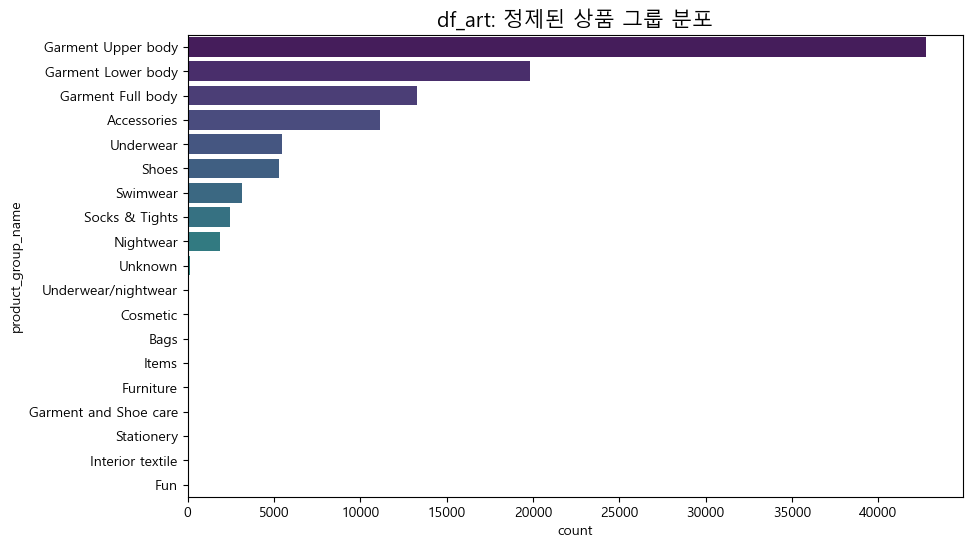

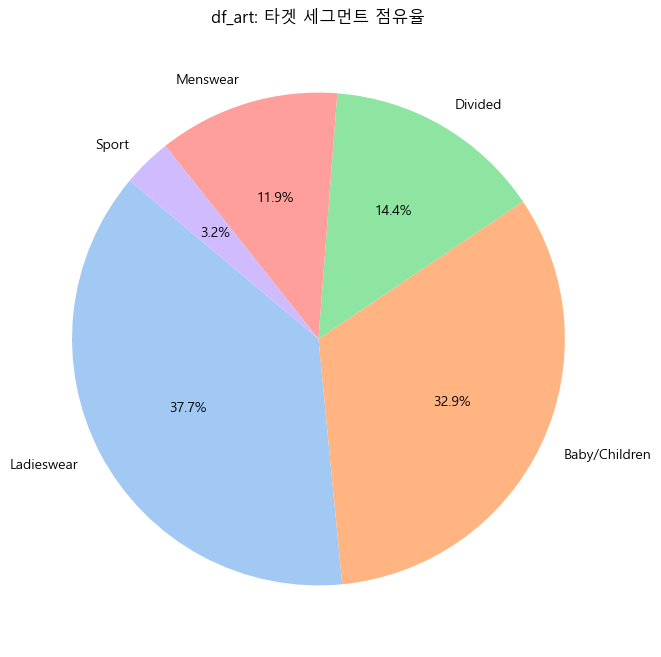

In [16]:

### 전처리 끝난 후의 EDA용 시각화
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 상품 그룹별 분포 (df_art_cleaned 사용)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_art_cleaned, y='product_group_name', 
              order=df_art_cleaned['product_group_name'].value_counts().index, palette='viridis')
plt.title('df_art: 정제된 상품 그룹 분포', fontsize=15)
plt.show()

# 2. 타겟층 비중 (Ladies/Mens/Baby)
plt.figure(figsize=(8, 8))
#카테고리 비중을 파이차트로 한 번에 보자
df_art_cleaned['index_group_name'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('df_art: 타겟 세그먼트 점유율')
plt.ylabel('')
plt.show()

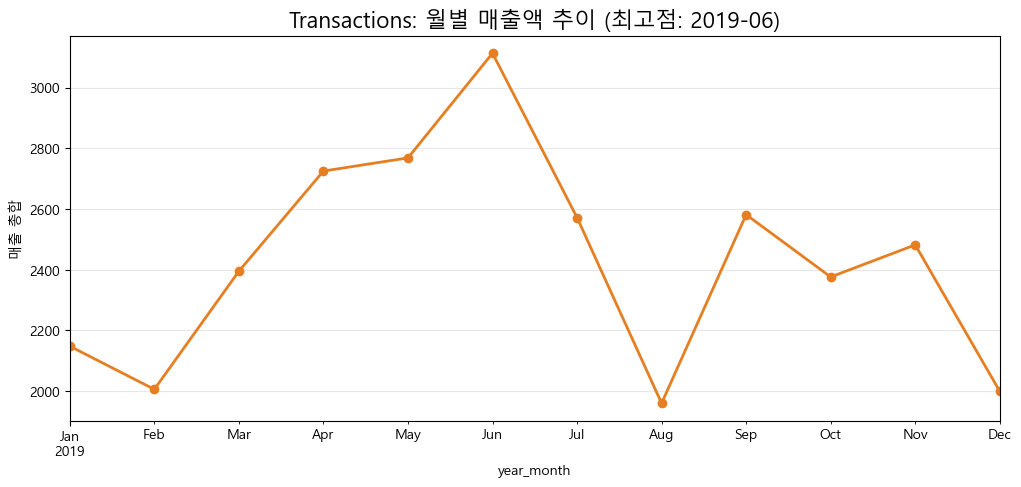

C:\Users\user\AppData\Local\Temp\ipykernel_7472\417388781.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=transactions, x='판매 채널', palette='Set2')


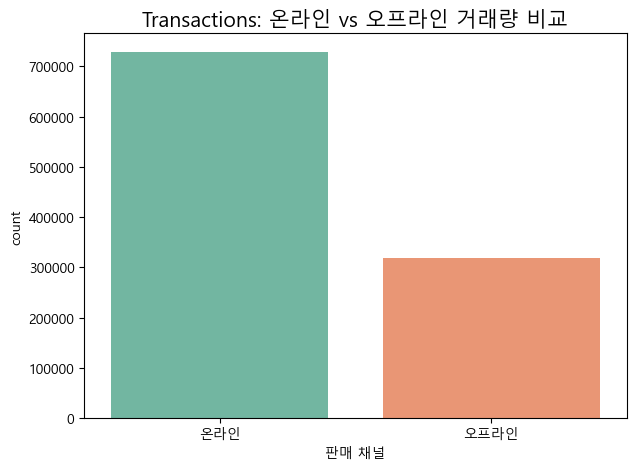

In [17]:
plt.figure(figsize=(12, 5))
monthly_price.plot(kind='line', marker='o', color='#e67e22', linewidth=2)
plt.title(f'Transactions: 월별 매출액 추이 (최고점: {best_month})', fontsize=16)
plt.ylabel('매출 총합')
plt.grid(True, alpha=0.3)
plt.show()

# 2. (추가) 판매 채널별 거래 비중 확인
plt.figure(figsize=(7, 5))
sns.countplot(data=transactions, x='판매 채널', palette='Set2')
plt.title('Transactions: 온라인 vs 오프라인 거래량 비교', fontsize=15)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_7472\987151097.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customer, x='age_segment', order=age_order, palette='BuGn')


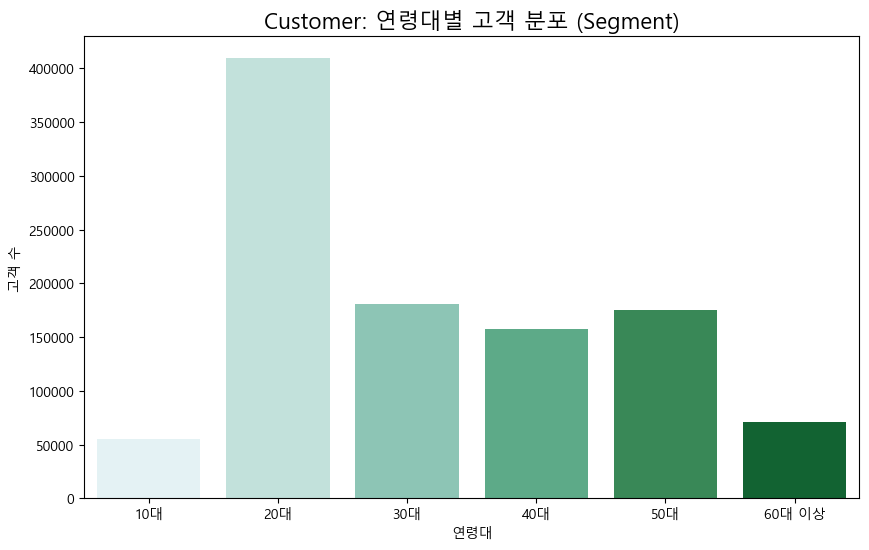

In [18]:
# 1. 연령대 세그먼트 분포 (Cate_age 결과 활용)
plt.figure(figsize=(10, 6))
age_order = ['10대', '20대', '30대', '40대', '50대', '60대 이상']
sns.countplot(data=customer, x='age_segment', order=age_order, palette='BuGn')
plt.title('Customer: 연령대별 고객 분포 (Segment)', fontsize=16)
plt.xlabel('연령대')
plt.ylabel('고객 수')
plt.show()

In [19]:
##매핑. 파생변수 생성하고 끝나기


## 1. 색상 그룹과 섹션 이름에 어떤 값들이 있는지 먼저 확인하기
print("--- Colour Group Names ---")
print(df_art['colour_group_name'].unique())

print("\n--- Section Names ---")
print(df_art['section_name'].unique())

#everyday가 붙으면 all_season
#sport, 

--- Colour Group Names ---
<StringArray>
[          'Black',           'White',       'Off White',     'Light Beige',
           'Beige',            'Grey',      'Light Blue',      'Light Grey',
       'Dark Blue',       'Dark Grey',            'Pink',        'Dark Red',
   'Greyish Beige',    'Light Orange',          'Silver',            'Gold',
      'Light Pink',       'Dark Pink', 'Yellowish Brown',            'Blue',
 'Light Turquoise',          'Yellow',  'Greenish Khaki',     'Dark Yellow',
      'Other Pink',     'Dark Purple',             'Red',     'Transparent',
      'Dark Green',       'Other Red',       'Turquoise',     'Dark Orange',
           'Other',          'Orange',      'Dark Beige',    'Other Yellow',
     'Light Green',    'Other Orange',          'Purple',       'Light Red',
    'Light Yellow',           'Green',    'Light Purple',  'Dark Turquoise',
    'Other Purple',   'Bronze/Copper', 'Other Turquoise',     'Other Green',
      'Other Blue',         'Unknow

In [20]:
# 1. 시즌 별 매핑 (product_season) / 시즌성 구분을 위한 키워드 정의
def get_season(section):
    section = section.lower()
    # FW
    if any(kw in section for kw in ['outerwear', 'nightwear', 'socks', 'tights', 'knitted']):
        return 'FW'
    # SS
    elif any(kw in section for kw in ['swimwear', 'sport', 'shorts', 'sandals']):
        return 'SS'
    # 두루두루 아이템(all season)
    else:
        return 'All-Season'

#파생변수 생성 및 이름만 조금 더 직관적으로 분류
df_art_cleaned['product_season'] = df_art_cleaned['section_name'].apply(get_season)
df_art_cleaned['category_main'] = df_art_cleaned['index_group_name']    #원본 보존하고 복사해서 이름 변경 (메인 카테고리 정의)

### ai의 추가 전략: 
아까 봤던 상품 카테고리 중 basic 라인이랑 콜라보 라인이 있었음.
* 상품의 복잡도/가치 세그먼트
* → 왜 해야하는가?
* Everyday_Basic (기본템): 
    * 단가는 낮지만, 고객이 매달 꾸준히 사는 물품. (예: 흰 티셔츠, 양말)
        * 어?.. 이거 어디서 봤는데 접근성 높고 구매빈도 높고 어디서나 파는(휴지 막이런거)
        * 편의품이었음 맞다 저관여 물품(와 이런 데서 쓸모가 있는 지식이네 몰랐다)

* Strategic_Trend (전략 아이템): 
    * 단가가 높고 마진이 좋음. 브랜드의 이미지를 결정하는 고관여 제품 
    * 고관여(선매품) 특 : 가격보다 가치 중시, 시즌성 높고 물품 비교하고 삼 (예: 트렌디한 자켓, 콜라보 제품)

In [21]:
# 2. 저관여/고관여 제품 분류?

def get_involvement_strategy(row):
    garment = str(row['garment_group_name']).lower()
    section = str(row['section_name']).lower()
    
    # 1. 저관여 (베이직)
    if any(kw in garment for kw in ['basic', 'underwear', 'socks', 'jersey']) or \
       'basic' in section:
        return 'Low_Involvement_Basic'
    
    # 2. 고관여 (전략템/트렌드템)
    elif any(kw in garment for kw in ['knitwear', 'outerwear', 'dresses']) or \
         any(kw in section for kw in ['trend', 'special']):
        return 'High_Involvement_Strategic'
    
    else:
        return 'General_Fashion'

# 파생변수 생성
df_art_cleaned['product_strategy'] = df_art_cleaned.apply(get_involvement_strategy, axis=1)

display(df_art_cleaned[['article_id', 'prod_name', 'product_strategy']].head()) #확인용

,article_id,prod_name,product_strategy
0,0108775015,Strap top,Low_Involvement_Basic
1,0108775044,Strap top,Low_Involvement_Basic
2,0108775051,Strap top (1),Low_Involvement_Basic
3,0110065001,OP T-shirt (Idro),General_Fashion
4,0110065002,OP T-shirt (Idro),General_Fashion


### 주의해야할 관점에서:
1. 시즌 매핑
    * → 시즌별 판매 추이, 재고/프로모션 분석 가능
    * 일부 아이템이 중복 키워드 포함 시 → ‘FW’ 우선 판단으로 고정됨
        * (예: knitted swimwear → FW로 매핑됨)
    * 키워드 누락 시 All-Season으로 잡히는데, 실제로는 FW/SS일 가능성 有
2. 관여도 전략 매핑
    * → 저관여/고관여 제품 전략 비교 분석 가능
    * ‘High_Involvement_Strategic’ vs ‘General_Fashion’ 경계가 키워드 정의에 의존 → 데이터 변화 시 재검토 필요
    * 대소문자 혼용 방지 위해 lower() 사용 → good

###참고용) palette 프리셋
1. 범주형(Categorical) 팔레트 (각 항목이 독립적일 때)
* palette='pastel': 부드럽고 편안한 느낌. (유아복/여성복 분석에 추천)
* palette='Set2': 색상 간 구분이 명확하여 보고서용으로 가장 깔끔함.
* palette='hls': 밝고 화사한 느낌을 주고 싶을 때 사용.


2. 연속형(Sequential) 팔레트 (값의 크기나 순서가 중요할 때)
* palette='viridis': 통계 분석의 정석. 가독성이 매우 뛰어남.
* palette='rocket': 짙은 빨간색 계열로, '매출 폭발'이나 '주의가 필요한 구간' 강조에 적합.
* palette='mako': 심해의 느낌을 주는 청록색 계열로, 차분하고 전문적인 느낌.
* palette='Blues': 전통적인 파란색 그라데이션.

3. 발산형(Diverging) 팔레트 (중앙값을 기준으로 양극단을 강조할 때(예: 평균 대비 매출 증감))
* palette='vlag': 차가운 색과 뜨거운 색의 대비.
* palette='coolwarm': 마이너스와 플러스, 혹은 저가와 고가 대비에 최적.

### 생각할 볼만한 파생 변수 
* 상품 수명주기
    * detail_desc/prod_name 을 통해 '신상품 여부' 판단할 수 있음
* colour_group_name
    * (인기 많은 2019 AW 이후로 어두운 색상이 인기가 많아졌다는데 그 부분을 확인하고 싶다면 따로 파생변수를 만들 수 있음)
* 신상품/트렌드 여부 (is_new)
    * 키워드 누락 가능성
        * 예: just arrived, hot pick 같은 키워드가 누락되면 Regular_Carryover로 잘못 분류됨
    * 데이터 크기가 크면 apply(axis=1) → 느려질 수 있음
        * → 벡터화 처리 고려 가능 (흠.. 어렵다)
* 색상 톤 그룹화 (color_tone)
    * DarkBlue vs dark blue vs navy → 누락 가능
    * 범주 세분화 : 레드 계열, 파스텔 계열 구분 필요하면 추가 분류 필요
    * 레드 계열, 파스텔 계열 구분 필요하면 추가 분류 필요 (실제 톤 분석하려면 따로 잡아야 하지만 분석 목적이 아니니 OK)

In [22]:
# 3. 신상품/트렌드 여부 파생변수
def check_newness(row):
    text = (str(row['prod_name']) + " " + str(row['detail_desc'])).lower()
    new_keywords = ['new', 'collection', 'latest', 'trend', 'exclusive']
    
    if any(kw in text for kw in new_keywords):
        return 'New_Arrival'
    return 'Regular_Carryover'
# 파생변수 생성
df_art_cleaned['is_new'] = df_art_cleaned.apply(check_newness, axis=1)

# 4. 색상 톤 그룹화 
def get_color_tone(color):
    color = str(color).lower()
    dark_colors = ['black', 'dark blue', 'dark grey', 'dark red', 'navy blue', 'dark green', 'anthracite']
    light_colors = ['white', 'light beige', 'off white', 'light pink', 'light blue', 'yellowish brown']
    
    if any(dc in color for dc in dark_colors):
        return 'Dark_Tone'
    elif any(lc in color for lc in light_colors):
        return 'Light_Tone'
    else:
        return 'Neutral_Tone'
# 파생변수 생성
df_art_cleaned['color_tone'] = df_art_cleaned['colour_group_name'].apply(get_color_tone)

Mapping / 파생변수 생성 완료 목록(articles)
* ▶ 중요
    * category_main (메인 카테고리 직관적 재정의) ▶ 메인 카테고리(원본의 카피)
    * product_season (시즌별 분류: FW / SS / All-Season) ▶ '시즌별' (필수 분석)
* ▷ 선택적
    * product_strategy (관여도 분류: 저관여 / 고관여 / 일반)
    * is_new (신상품 여부: 신상 / 상시판매)
    * color_tone (색감 분류: Dark / Light / Neutral)

In [23]:
# !python -m jupyter nbconvert --to markdown 파일명.ipynb

In [ ]:
#!jupyter nbconvert --to markdown "01_articles_preprocessing.ipynb"

[NbConvertApp] Converting notebook 01_articles_preprocessing.ipynb to markdown
[NbConvertApp] Support files will be in 01_articles_preprocessing_files\
[NbConvertApp] Writing 30983 bytes to 01_articles_preprocessing.md
